# Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions



## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments in previous weeks. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be maximized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake model exercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in previous assignments had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100). Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a more advanced way of deciding on the amout of anhtropogenic polution. We will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following [Quinn et al. 2017](http://www.sciencedirect.com/science/article/pii/S1364815216302250) and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

**To formulate this problem, do the following:**

**1) Import the lake model function from dps_lake_model.py**

**2) Create an ema_workbench interface for this problem, with corresponding uncertainties, levers and outcomes as specified above**




In [1]:
# from ema_workbench import (Model, RealParameter, ScalarOutcome)
#
# from dps_lake_model import lake_model
#
# model = Model('lakeproblem', function=lake_model)
#
# #specify uncertainties
# model.uncertainties = [RealParameter('b', 0.1, 0.45),
#                        RealParameter('q', 2.0, 4.5),
#                        RealParameter('mean', 0.01, 0.05),
#                        RealParameter('stdev', 0.001, 0.005),
#                        RealParameter('delta', 0.93, 0.99)]
#
# # set levers
# model.levers = [RealParameter("c1", -2, 2),
#                 RealParameter("c2", -2, 2),
#                 RealParameter("r1", 0, 2),
#                 RealParameter("r2", 0, 2),
#                 RealParameter("w1", 0, 1)]
#
# #specify outcomes
# # note how we need to explicitely indicate the direction
# model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
#                   ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
#                   ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
#                   ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

In [2]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# # from __future__ import (unicode_literals, print_function, absolute_import, division)
#
# from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, ScalarOutcome, Policy,
#                            RealParameter, CategoricalParameter, IntegerParameter, optimize, Scenario)
#
# from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
# from ema_workbench.util import ema_logging
# from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties, LHSSampler
# from ema_workbench.em_framework.salib_samplers import SobolSampler, MorrisSampler
# from ema_workbench import save_results, load_results
# from ema_workbench.analysis import parcoords
# from ema_workbench.analysis import prim
#
# from problem_formulation2 import get_model_for_problem_formulation#, sum_over, sum_over_time
#
#
# # parameter definition for visualization libraries
# plt.rcParams["figure.figsize"] = (10, 6)
# sns.set_style("whitegrid")
# #name the specific dikes
# dikes = [f"A.{i+1}" for i in range(5)]
#
# #problem formulation selection
# #pf = 3
# problem_formulation_id = 0
# direction = ScalarOutcome.MINIMIZE
# #Dependent on problem formulation used, outcomes are defined
# if problem_formulation_id == 0:
#     damage_variables = [f"{dike}_Expected Annual Damage" for dike in ['A.1', 'A.2', 'A.3']]
#     rfr_cost_variables = ["RfR Total Costs"]
#     dike_cost_variables = [f"{dike}_Dike Investment Costs" for dike in ['A.1', 'A.2', 'A.3']]
#
#     outcomes = [
#         ScalarOutcome(
#             "Expected Annual Damage",
#             variable_name=damage_variables,
#             kind=direction,
#         ),
#         ScalarOutcome(
#             "RfR Total Costs",
#             variable_name=rfr_cost_variables,
#             kind=direction,
#         ),
#         ScalarOutcome(
#             "Dike Investment Costs",
#             variable_name=dike_cost_variables,
#             kind=direction,
#         ),
#     ]
#
#
# # Uncertainties are defined uniformous, independent of problem formulation
# uncertainties = [IntegerParameter('A.0_ID flood wave shape', 0, 133),
#                    RealParameter('A.1_Bmax', 30,350),
#                    CategoricalParameter('A.1_Brate',(0.9,1.5,1000)),
#                    RealParameter('A.1_pfail',0,1),
#                    RealParameter('A.2_Bmax', 30,350),
#                    CategoricalParameter('A.2_Brate',(0.9,1.5,1000)),
#                    RealParameter('A.2_pfail',0,1),
#                    RealParameter('A.3_Bmax', 30,350),
#                    CategoricalParameter('A.3_Brate',(0.9,1.5,1000)),
#                    RealParameter('A.3_pfail',0,1),
#                    RealParameter('A.4_Bmax', 30,350),
#                    CategoricalParameter('A.4_Brate',(0.9,1.5,1000)),
#                    RealParameter('A.4_pfail',0,1),
#                    RealParameter('A.5_Bmax', 30,350),
#                    CategoricalParameter('A.5_Brate',(0.9,1.5,1000)),
#                    RealParameter('A.5_pfail',0,1),
#                    CategoricalParameter('discount rate 1',(1.5,2.5,3.5,4.5)),
#                    CategoricalParameter('discount rate 2',(1.5,2.5,3.5,4.5))]
#
# # Analogous to uncertainties model levers are defined
# levers = [IntegerParameter('A.1_DikeIncrease',0,10),
#                      IntegerParameter('A.2_DikeIncrease',0,10),
#                      IntegerParameter('A.3_DikeIncrease',0,10),
#                      IntegerParameter('A.4_DikeIncrease',0,10),
#                      IntegerParameter('A.5_DikeIncrease',0,10),
#                      IntegerParameter('1_RfR 0',0,1),
#                      IntegerParameter('2_RfR 0',0,1),
#                      IntegerParameter('3_RfR 0',0,1),
#                      IntegerParameter('4_RfR 0',0,1),
#                      IntegerParameter('0_RfR 0',0,1),
#                      IntegerParameter('EWS_DaysToThreat',0,4)]
#
# if __name__ == '__main__':
#     ema_logging.log_to_stderr(ema_logging.INFO)
#
#     dike_model, function_planning_steps = get_model_for_problem_formulation(problem_formulation_id)
#
#     #setting up the reference scenario - needed for MORDM
#     reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
#                         'discount rate': 3.5,
#                         'ID flood wave shape': 4}
#
#     # Definition of scenario-dictionary for later creation of policy class-instance for reference scenario
#     scen1 = {}
#
#     # reference scenario updated for all dike rings
#     for key in dike_model.uncertainties:
#         name_split = key.name.split('_')
#         if len(name_split) == 1:
#             if key.name in reference_values.keys():
#                 scen1.update({key.name: reference_values[name]})
#         else:
#             scen1.update({key.name: reference_values[name_split[1]]})
#
#     #setting so that the reference scenario
#     ref_scenario = Scenario('reference', **scen1)
#
#     #setting up dike model uncertainties and potential ranges
#     dike_model.uncertainties = uncertainties
#
#     # set levers
#     dike_model.levers = levers
#
#     # set convergence metrics
#     convergence_metrics = [EpsilonProgress()]
#
#     # set nfe
#     #nfe = 100000
#     nfe=50

In [4]:
# #run optimization
# if __name__ == '__main__':
#     with MultiprocessingEvaluator(dike_model) as evaluator:
#             results, convergence = evaluator.optimize(nfe=nfe,
#                                                       searchover='levers',
#                                                       epsilons=[0.1,]*len(dike_model.outcomes),
#                                                       convergence=convergence_metrics,
#                                                       reference=ref_scenario
#                                                       )

In [5]:
# results

In [6]:
# #done on another machine and imported here due to computational power
# #results = pd.read_csv("results/results_convergence_robustness_40000.csv")
# #gives results across each of the dike rings for problem_formulation (3)
# for i in range(5):
#
#         data = results.loc[:, [f"Dike Investment Costs",
#                                f"Expected Annual Damage",
#                                f"RfR Total Costs",
#                                ]]
#
#         limits = parcoords.get_limits(data)
#         limits.loc[0, [f"Expected Annual Damage",
#                                f"RfR Total Costs",
#                                f"Dike Investment Costs",
#                                ]] = 0
#
#         paraxes = parcoords.ParallelAxes(limits)
#         paraxes.plot(data)
#
#         #paraxes.invert_axis('max_P')
#         plt.show()
# #plt.savefig(f"parcords_dikering_A.{i+1}.png", dpi=300)

In [7]:
# data = results.loc[:, [f"Dike Investment Costs",
# f"Expected Annual Damage",
# f"RfR Total Costs",
# ]]
#
# limits = parcoords.get_limits(data)
# limits.loc[0, [f"Expected Annual Damage",
# f"RfR Total Costs",
# f"Dike Investment Costs",
# ]] = 0
#
# paraxes = parcoords.ParallelAxes(limits)
# paraxes.plot(data)
#
# #paraxes.invert_axis('max_P')
# plt.show()

In [8]:
from ema_workbench import (Model, RealParameter, CategoricalParameter, IntegerParameter, ScalarOutcome)
from dike_model_function import DikeNetwork
import numpy as np
# from __future__ import (unicode_literals, print_function, absolute_import, division)

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, ScalarOutcome, Policy,
                           RealParameter, CategoricalParameter, IntegerParameter, optimize, Scenario)

from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties, LHSSampler
from ema_workbench.em_framework.salib_samplers import SobolSampler, MorrisSampler
from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim

from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

# model
dike_model = Model('dikeproblem', function=DikeNetwork())

# specify uncertainties
dike_model.uncertainties = [
    # uncertainties per dike
    RealParameter('A.1_Bmax', 30, 350),
    RealParameter('A.1_pfail', 0, 1),
    CategoricalParameter('A.1_Brate', [1.0, 1.5, 10]),

    RealParameter('A.2_Bmax', 30, 350),
    RealParameter('A.2_pfail', 0, 1),
    CategoricalParameter('A.2_Brate', [1.0, 1.5, 10]),

    RealParameter('A.3_Bmax', 30, 350),
    RealParameter('A.3_pfail', 0, 1),
    CategoricalParameter('A.3_Brate', [1.0, 1.5, 10]),

    RealParameter('A.4_Bmax', 30, 350),
    RealParameter('A.4_pfail', 0, 1),
    CategoricalParameter('A.4_Brate', [1.0, 1.5, 10]),

    RealParameter('A.5_Bmax', 30, 350),
    RealParameter('A.5_pfail', 0, 1),
    CategoricalParameter('A.5_Brate', [1.0, 1.5, 10]),

    # discount rate per planning step (planning_steps = [0,1,2])
    CategoricalParameter('discount rate 0', [1.5, 2.5, 3.5, 4.5]),
    CategoricalParameter('discount rate 1', [1.5, 2.5, 3.5, 4.5]),
    CategoricalParameter('discount rate 2', [1.5, 2.5, 3.5, 4.5]),

    # flood wave shape
    IntegerParameter('A.0_ID flood wave shape', 0, 132)
]

# set levers
dike_model.levers = [
    # DikeIncrease per dike en per planning step
    IntegerParameter('A.1_DikeIncrease 0', 0, 10),
    IntegerParameter('A.1_DikeIncrease 1', 0, 10),
    IntegerParameter('A.1_DikeIncrease 2', 0, 10),

    IntegerParameter('A.2_DikeIncrease 0', 0, 10),
    IntegerParameter('A.2_DikeIncrease 1', 0, 10),
    IntegerParameter('A.2_DikeIncrease 2', 0, 10),

    IntegerParameter('A.3_DikeIncrease 0', 0, 10),
    IntegerParameter('A.3_DikeIncrease 1', 0, 10),
    IntegerParameter('A.3_DikeIncrease 2', 0, 10),

    IntegerParameter('A.4_DikeIncrease 0', 0, 10),
    IntegerParameter('A.4_DikeIncrease 1', 0, 10),
    IntegerParameter('A.4_DikeIncrease 2', 0, 10),

    IntegerParameter('A.5_DikeIncrease 0', 0, 10),
    IntegerParameter('A.5_DikeIncrease 1', 0, 10),
    IntegerParameter('A.5_DikeIncrease 2', 0, 10),

    # RfR per project en per planning step (5 projecten: 0 t/m 4)
    IntegerParameter('0_RfR 0', 0, 1),
    IntegerParameter('0_RfR 1', 0, 1),
    IntegerParameter('0_RfR 2', 0, 1),

    IntegerParameter('1_RfR 0', 0, 1),
    IntegerParameter('1_RfR 1', 0, 1),
    IntegerParameter('1_RfR 2', 0, 1),

    IntegerParameter('2_RfR 0', 0, 1),
    IntegerParameter('2_RfR 1', 0, 1),
    IntegerParameter('2_RfR 2', 0, 1),

    IntegerParameter('3_RfR 0', 0, 1),
    IntegerParameter('3_RfR 1', 0, 1),
    IntegerParameter('3_RfR 2', 0, 1),

    IntegerParameter('4_RfR 0', 0, 1),
    IntegerParameter('4_RfR 1', 0, 1),
    IntegerParameter('4_RfR 2', 0, 1),

    # Early Warning System
    IntegerParameter('EWS_DaysToThreat', 0, 4)
]

damage_variables = [f"{dike}_Expected Annual Damage" for dike in ['A.1', 'A.2', 'A.3']]
rfr_cost_variables = ["RfR Total Costs"]
dike_cost_variables = [f"{dike}_Dike Investment Costs" for dike in ['A.1', 'A.2', 'A.3']]

dike_model.outcomes = [
    ScalarOutcome(
        "Expected Annual Damage",
        variable_name=damage_variables,
        kind=ScalarOutcome.MINIMIZE,
        function=sum_over,
    ),
    ScalarOutcome(
        "RfR Total Costs",
        variable_name=rfr_cost_variables,
        kind=ScalarOutcome.MINIMIZE,
        function=sum_over,
    ),
    ScalarOutcome(
        "Dike Investment Costs",
        variable_name=dike_cost_variables,
        kind=ScalarOutcome.MINIMIZE,
        function=sum_over,
    ),
]



## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

Take the model interface developed in the previous step and use the optimization functionality of the workbench to identify the pareto approximate set of solutions. Try the following:
* change the epsilon values between 0.01 and 0.1, what changes, why?


In [9]:
#setting up the reference scenario - needed for MORDM
reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate': 3.5,
                    'ID flood wave shape': 4}

# Definition of scenario-dictionary for later creation of policy class-instance for reference scenario
scen1 = {}

# reference scenario updated for all dike rings
for key in dike_model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in reference_values.keys():
            scen1.update({key.name: reference_values[name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

#setting so that the reference scenario
ref_scenario = Scenario('reference', **scen1)

# #setting up dike model uncertainties and potential ranges
# dike_model.uncertainties = uncertainties
#
# # set levers
# dike_model.levers = levers

# set convergence metrics
convergence_metrics = [EpsilonProgress()]

# set nfe
#nfe = 100000
#nfe=50
#nfe=250
nfe = 1000

In [10]:
#run optimization
if __name__ == '__main__':
    with MultiprocessingEvaluator(dike_model) as evaluator:
            results1, convergence = evaluator.optimize(nfe=nfe,
                                                      searchover='levers',
                                                      epsilons=[0.1,]*len(dike_model.outcomes),
                                                      convergence=convergence_metrics,
                                                      reference=ref_scenario
                                                      )

100%|██████████████████████████████████████| 1000/1000 [01:06<00:00, 14.93it/s]


In [11]:
#run optimization
if __name__ == '__main__':
    with MultiprocessingEvaluator(dike_model) as evaluator:
            results2, convergence = evaluator.optimize(nfe=nfe,
                                                      searchover='levers',
                                                      epsilons=[0.01,]*len(dike_model.outcomes),
                                                      convergence=convergence_metrics,
                                                      reference=ref_scenario
                                                      )

100%|██████████████████████████████████████| 1000/1000 [01:01<00:00, 16.23it/s]


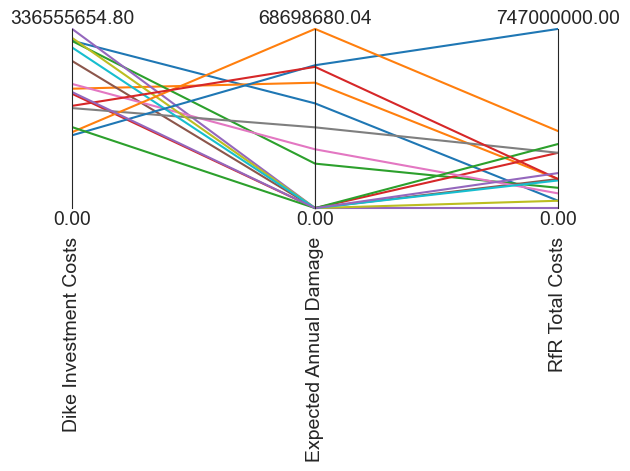

In [12]:
data1 = results1.loc[:, [f"Dike Investment Costs",
f"Expected Annual Damage",
f"RfR Total Costs",
]]

limits1 = parcoords.get_limits(data1)
limits1.loc[0, [f"Expected Annual Damage",
f"RfR Total Costs",
f"Dike Investment Costs",
]] = 0

paraxes1 = parcoords.ParallelAxes(limits1)
paraxes1.plot(data1)
plt.show()

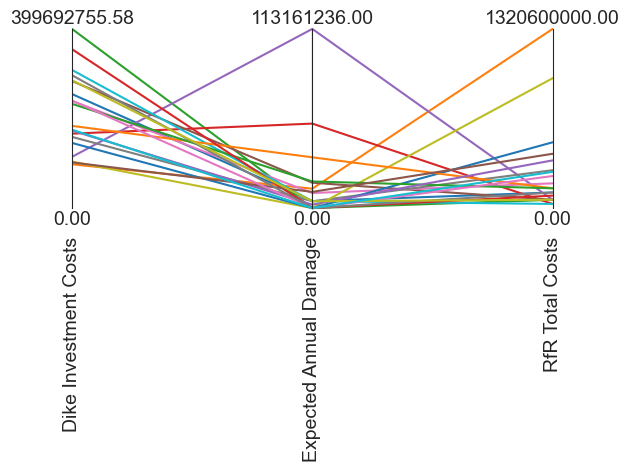

In [13]:
data2 = results2.loc[:, [f"Dike Investment Costs",
f"Expected Annual Damage",
f"RfR Total Costs",
]]

limits2 = parcoords.get_limits(data2)
limits2.loc[0, [f"Expected Annual Damage",
f"RfR Total Costs",
f"Dike Investment Costs",
]] = 0

paraxes2 = parcoords.ParallelAxes(limits2)
paraxes2.plot(data2)
plt.show()

In [14]:
# from ema_workbench import Model
#
# class PatchedDikeModel(Model):
#     def run_experiment(self, experiment):
#         experiment = experiment.copy()
#
#         # Provide fallback keys in case the model incorrectly looks for unprefixed ones
#         for dike in ["A.1", "A.2", "A.3"]:
#             for step in [0, 1, 2]:
#                 full_key = f"{dike}_DikeIncrease {step}"
#                 wrong_key = f"DikeIncrease {step}"
#                 # Only patch if not already set (avoid overwriting correct ones)
#                 if full_key in experiment and wrong_key not in experiment:
#                     experiment[wrong_key] = experiment[full_key]
#
#         return super().run_experiment(experiment)
#
# patched_model = PatchedDikeModel(name=model.name, function=model.function)
# patched_model.uncertainties = model.uncertainties
# patched_model.levers = model.levers
# patched_model.outcomes = model.outcomes

In [15]:
# from ema_workbench import SequentialEvaluator
#
# with SequentialEvaluator(patched_model) as evaluator:
#     results = evaluator.optimize(nfe=500, searchover='levers',  # lower nfe for speed
#                                  epsilons=[0.1] * len(patched_model.outcomes))

In [16]:
# epsilons= [.005, .005, .005, .005, .005]
# convergence = [EpsilonProgress()]
#
# # convergence = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1e+08, 1e+09, 1e+10, 1000, .1]),
# #                EpsilonProgress()]
# with MultiprocessingEvaluator(model) as evaluator:
#     output = evaluator.optimize(nfe=nfe, searchover='levers', reference = scenarios[case],
#                                               epsilons=epsilons,
#                                               convergence=convergence)

In [17]:
# from ema_workbench import MultiprocessingEvaluator, ema_logging
#
# ema_logging.log_to_stderr(ema_logging.INFO)
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.optimize(nfe=250, searchover="levers", epsilons=[0.1] * len(dike_model.outcomes))

In [18]:
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results2 = evaluator.optimize(nfe=5e3, searchover='levers',
#                                  epsilons=[0.01,]*len(dike_model.outcomes))

In [19]:
# from ema_workbench.analysis import parcoords
#
# data = results1.loc[:, [o.name for o in model.outcomes]]
# limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0
#
# paraxes = parcoords.ParallelAxes(limits)
# paraxes.plot(data)
# paraxes.invert_axis('max_P')
# plt.show()

In [20]:
# data = results2.loc[:, [o.name for o in model.outcomes]]
# limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0
#
# paraxes = parcoords.ParallelAxes(limits)
# paraxes.plot(data)
# paraxes.invert_axis('max_P')
# plt.show()

The above parallel coordinate plots are consistent with our expectation. If we use a lower value for epsilon, we have many more solutions in the pareto approximate set.

* change the number of function evaluations from 1000 to 10.000 (this requires using multiprocessing unless you are very patient). What is the difference? You can use  convergence as explained in assignment 7 for this

Calculating hypervolume can be tricky. It requires specifying the minimum and maximum values that can occur. That is, we basically have to describe the hyperbox within which hypervolume needs to be calculated. There are various ways we can ensure this. For example we take the values quite broad to be certain. We can also add constraints to the outcome space. A common practice, however, is to use the minima and maxima from a reference set. This reference set can come from various sources. In some cases we have analytical solutions which we can use for the reference set. However, in many real world problems such analytical solutions don't exist. So, instead we use as a reference set, the set of best known solutions (*i.e.*, the final archive, or the set of archives merged across multiple seeds). This is also what I do below.

Calculating hypervolume is computationally expensive. Therefore, it might sometimes be better to simply log the state of the achive at each generation, and only calculate hypervolume afterwards. See the [ArchiveLogger](http://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/optimization.html#ema_workbench.em_framework.optimization.ArchiveLogger) which you can use just like other convergence metrics for details


In [21]:
import random

random.seed(20)

In [22]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)
#
# convergence_metrics = [
#     ArchiveLogger(
#         "./archives",
#         [l.name for l in dike_model.levers],
#         [o.name for o in dike_model.outcomes],
#         base_filename="dike_mordm_1.tar.gz",
#     ),
#     EpsilonProgress(),
# ]
#
# with MultiprocessingEvaluator(dik_model) as evaluator:
#     results, convergence = evaluator.optimize(nfe=1e3, searchover='levers',
#                                  convergence=convergence_metrics,
#                                  epsilons=[0.1,]*len(dike_model.outcomes))

In [23]:
# archives = ArchiveLogger.load_archives("./archives/dike_mordm_1.tar.gz")

In [24]:
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem
#
# reference_set = results
# problem = to_problem(dike_model, searchover="levers")
#
# hv = HypervolumeMetric(reference_set, problem)
#
# hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
# hypervolume.sort(key=lambda x:x[0])
# hypervolume = np.asarray(hypervolume)


In [25]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
# ax1.plot(convergence.nfe, convergence.epsilon_progress)
# ax1.set_ylabel(r'$\epsilon$-progress')
# ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
# ax2.set_ylabel('hypervolume')
#
# ax1.set_xlabel('number of function evaluations')
# ax2.set_xlabel('number of function evaluations')
# plt.show()

In [26]:
# convergence_metrics = [
#     ArchiveLogger(
#         "./archives",
#         [l.name for l in dike_model.levers],
#         [o.name for o in dike_model.outcomes],
#         base_filename="dike_mordm_2.tar.gz",
#     ),
#     EpsilonProgress(),
# ]
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results, convergence = evaluator.optimize(nfe=1e4, searchover='levers',
#                                  convergence=convergence_metrics,
#                                  epsilons=[0.1,]*len(dike_model.outcomes))

In [27]:
# archives = ArchiveLogger.load_archives("./archives/dike_mordm_2.tar.gz")
#
# reference_set = results
# problem = to_problem(dike_model, searchover="levers")
#
# hv = HypervolumeMetric(reference_set, problem)
#
# hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
# hypervolume.sort(key=lambda x:x[0])
# hypervolume = np.asarray(hypervolume)

In [28]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
# ax1.plot(convergence.nfe, convergence.epsilon_progress)
# ax1.set_ylabel(r'$\epsilon$-progress')
# ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
# ax2.set_ylabel('hypervolume')
#
# ax1.set_xlabel('number of function evaluations')
# ax2.set_xlabel('number of function evaluations')
# plt.show()

As you can see, the optimization has converged better in the second case with the higher number of function evaluations. Note also how in this particular case, search seems to stagnate before picking up again close to 10,000. So, to be certain, it would be good practice to use an even larger number of nfe (I would start wtih at least 50k, preferably even 250k), as shown below.



In [29]:
convergence_metrics = [
    ArchiveLogger(
        "./archives",
        [l.name for l in dike_model.levers],
        [o.name for o in dike_model.outcomes],
        base_filename="dike_mordm_3.tar.gz",
    ),
    EpsilonProgress(),
]


### DIT MOET NFE=1e5 worden
if __name__ == '__main__':
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results, convergence = evaluator.optimize(nfe=1e5, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=[0.1,]*len(dike_model.outcomes),
                                     reference=ref_scenario)

100183it [2:00:50, 13.82it/s]                                                  


In [30]:
from ema_workbench.em_framework.optimization import ArchiveLogger

# Laad het enige archief dat je hebt
all_archives = []

archives = ArchiveLogger.load_archives("./archives/dike_mordm_3.tar.gz")
all_archives.append(archives)


In [31]:
#all_archives
#archives

In [32]:
#results

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem

reference_set = results
problem = to_problem(dike_model, searchover="levers")

In [36]:
hv = HypervolumeMetric(reference_set, problem)

EMAError: Parameter names ['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2'] not found in archive

In [37]:

hypervolume = [(nfe, hv.calculate(all_archives)) for nfe, all_archives in all_archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

AttributeError: 'list' object has no attribute 'items'

In [38]:
|# from ema_workbench.em_framework.optimization import epsilon_nondominated, to_problem
#
# archives = ArchiveLogger.load_archives("./archives/dike_mordm_3.tar.gz")
#
# problem = to_problem(dike_model, searchover="levers")
# # reference_set = results
# reference_set = epsilon_nondominated([results], [0.05] * len(dike_model.outcomes), problem)
# # problem = to_problem(dike_model, searchover="levers")
#
# hv = HypervolumeMetric(reference_set, problem)
#
# hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
# hypervolume.sort(key=lambda x:x[0])
# hypervolume = np.asarray(hypervolume)

SyntaxError: invalid syntax (2276048738.py, line 1)

NameError: name 'hypervolume' is not defined

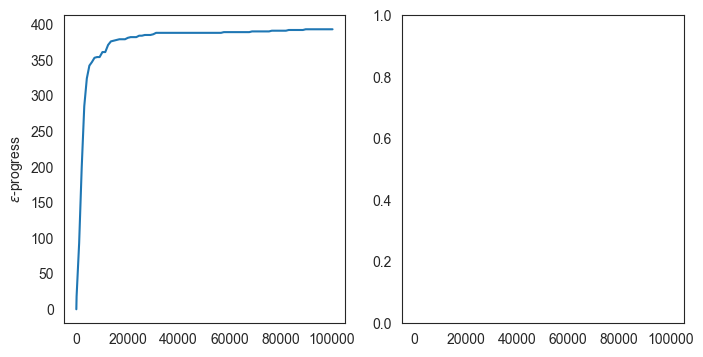

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylim(ymin=0)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

As we can more clearly see here, the early stalled search we saw was an artifact and we need at least 100k before we can have some confidence in convergence.

**plot the tradeoffs you have found using a parallel axis plot**

We can visualize these tradeoffs on a **parallel axis plots**. In these plots, each dimension is shown as a vertical axis. Each solution is represented by a line on this plot, which crosses the objective axes at the corresponsing value. You can use the [parcoords functionality](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html) for this that comes with the ema_workbench. Ensure that the direction of desirability is the same for the four objectives.|



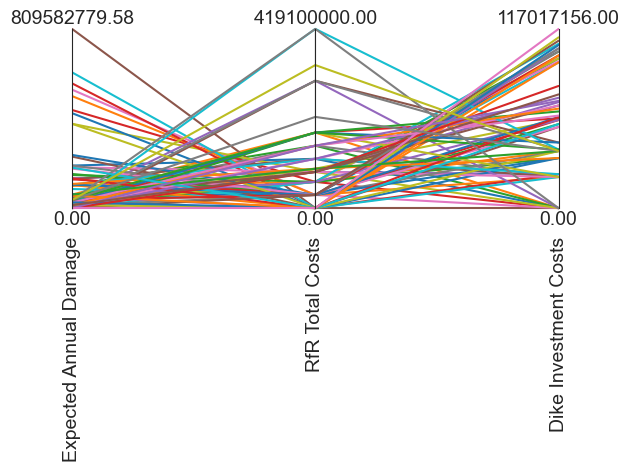

In [40]:
data = results.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [f"Expected Annual Damage",
f"RfR Total Costs",
f"Dike Investment Costs",
]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

Max_P is negatively correlated with utility and intertia, and positevely with reliability. if we look at inertia, there are two solutions which sacrifice intertia for higher scores on reliability. These might reflect a different correlation structure, or be evidence of incomplete convergence. 


## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_results**

**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a format that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

There are various ways to do it. One way is to use logical indexing. Basically, create a boolean vector that indicates for each row if the constraint is met or not. Next, we can use this as an index on the dataframe to get only the rows for which the index is true.




In [41]:
logical = results['Dike Investment Costs'] < 6000000000
np.sum(logical)

np.int64(69)

2 solutions is better, so we can proceed.

In [42]:
results[logical]

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,...,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,Expected Annual Damage,RfR Total Costs,Dike Investment Costs
0,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,3,1.922199e+08,115300000.0,0.000000e+00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6.106860e+07,176700000.0,0.000000e+00
2,0,0,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,3,1.012949e+08,146000000.0,0.000000e+00
3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,3,4.433509e+08,61400000.0,0.000000e+00
4,0,0,0,2,0,0,4,0,0,4,...,0,0,0,0,0,0,0,2.589081e+07,84600000.0,6.922180e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,0,0,3,0,0,2,0,0,7,...,0,0,0,0,0,0,2,0.000000e+00,146000000.0,7.001052e+07
65,0,0,0,3,0,0,4,0,0,6,...,0,0,0,0,0,0,2,1.333797e+07,84600000.0,7.424608e+07
66,2,0,0,4,0,0,4,0,0,1,...,0,0,0,0,0,0,3,0.000000e+00,0.0,1.170172e+08
67,2,0,0,0,0,0,0,0,0,4,...,1,0,0,0,0,0,3,3.698084e+07,213300000.0,3.725520e+07


In [43]:
policies = results[logical]
policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
policies

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,...,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat
0,0,0,0,0,0,0,0,0,0,4,...,0,1,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,7,...,0,1,1,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,3,...,0,1,1,0,0,0,0,0,0,3
4,0,0,0,2,0,0,4,0,0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,0,0,3,0,0,2,0,0,7,...,0,1,1,0,0,0,0,0,0,2
65,0,0,0,3,0,0,4,0,0,6,...,0,0,0,0,0,0,0,0,0,2
66,2,0,0,4,0,0,4,0,0,1,...,0,0,0,0,0,0,0,0,0,3
67,2,0,0,0,0,0,0,0,0,4,...,1,1,1,1,0,0,0,0,0,3


In [44]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyparallel, don't forget to start ipcluster.

In [45]:
# DIT MOET 1000 WORDEN
n_scenarios = 1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)


100%|████████████████████████████████████| 69000/69000 [57:03<00:00, 20.16it/s]


We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow range of uncertainty about the outcomes. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation should be different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [58]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

There are various ways in which we could calculate the signal to noise ratio. Here, I choose to iterate over the policy first. Next, I iterate over the outcomes. For each outcome, I only retrieve the results associated with the current policy. Next, I can calculate the signal to noise ratio. 

I am reusing the direction that we already specified for each outcome of interest, to avoid duplicating code. Note that I enabled this already with how I defined the s_to_n function above.

To make visualization easy, I transform all my results into a dataframe at the end.

In [59]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,RfR Total Costs,Dike Investment Costs
0,5.432023e+17,115300000.0,0.0
1,3.391891e+17,176700000.0,0.0
10,4.428552e+17,30700000.0,97668143.0
11,1.130626e+18,30700000.0,20299287.0
12,3.593512e+17,61400000.0,102241437.0
...,...,...,...
67,3.988433e+17,213300000.0,37255203.0
68,3.797378e+17,334500000.0,37255203.0
7,3.608329e+17,146000000.0,20299287.0
8,7.378320e+17,84600000.0,0.0


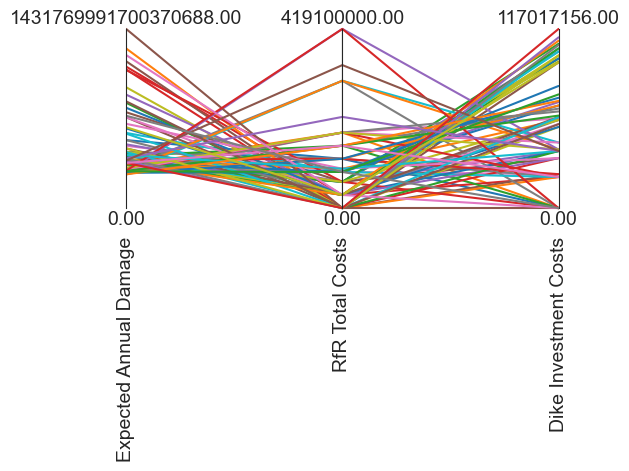

In [60]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, [f"Expected Annual Damage",
f"RfR Total Costs",
f"Dike Investment Costs",
] ] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()


The ideal solution would be a a high Signal to Noise score for reliability, inertia, and utility, and a low score for max_P. Such a solution clearly does not exist. The best solution for max_P and reliability score low on inertia and utility. No compromise solution can thus be found in this case. 


Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret for both kinds of outcome indicators. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [61]:
def calculate_regret(data, best):
    return np.abs(best-data)

Regret is the performance difference between the best possible outcome in a scenario across policies, the the observed outcome for a given policy. We have in this case both minimization and maximization. Best means the lowest in case of mimimization, and heighest in case of maximization. To avoid having to explicitly account for this in how we calculate the difference, we can simply take the absolute value of the difference. In this case, max_P will return negative regret values for `best-data`, so by taking the absolute value, we fix this

The next part of the code is probably the most tricky part. We need to find the best possible outcome for each scenario. We could do this by iterating over the scenario_id column in the experiment array. But we can also use pandas instead as done below. Wat we do is the following:
1. we create a dataframe with the outcome, the name of the policy and the scenario. This is a so called long-form representation of the data
2. We want to have the results for each policy side by side so we can take the max, or min accross the column. The pivot method on the DataFrame does this for us
3. We take the maximum or minimum accross the row.

In [62]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

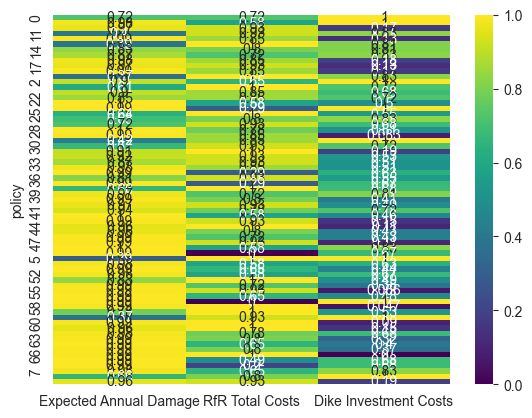

In [63]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

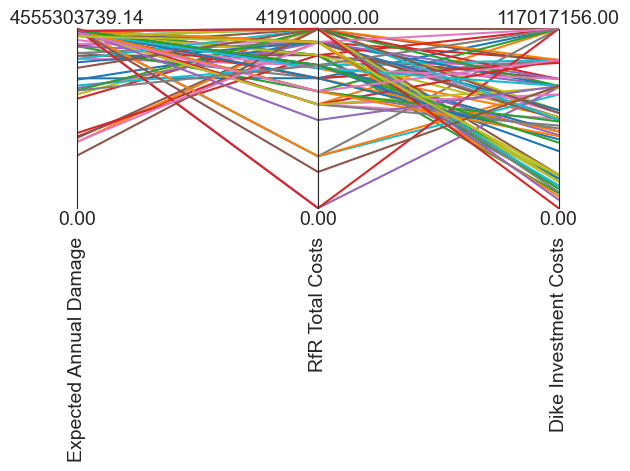

In [64]:

colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, [f"Expected Annual Damage",
f"RfR Total Costs",
f"Dike Investment Costs",
]] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index))
plt.show()

we clearly see a tradeoff between robustsness on maximum pollution and utility versus inertia and reliability. There is no compromise solution.

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it


In [65]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

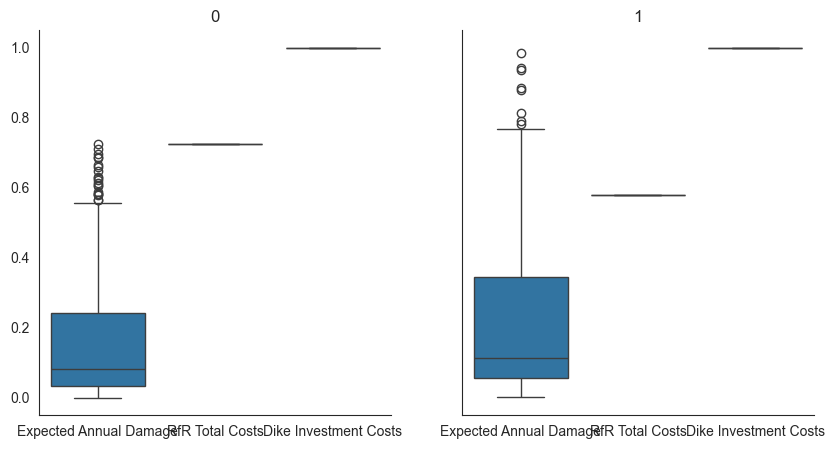

In [66]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

This is in line with the maximum regret parallel coordinates plot, but we get some more details.

We now have an understanding of which solutions have decent robustness using 2 different robustness metrics. 

A related but different question is to assess the uncertain conditions under which we get poor performance. For this, we can use scenario discovery. Since we want to identify the uncertainties only, we can remove the policy and lever columns from the experiments DataFrame. 

**Perform Scenario Discovery, focussed on understanding the conditions under which utility is lower than 0.35**

note that it might happen that no scenario exists where this is the case. If so, increase the threshold to say 0.5 instead.


In [67]:
# from ema_workbench.analysis import prim
#
# x = experiments.drop(columns=['policy', 'c1','c2', 'r1', 'r2', 'w1'])
# y = outcomes['utility'] < 0.5
#
# prim_alg = prim.Prim(x, y, threshold=0.5)
# box = prim_alg.find_box()

In [68]:
# box.inspect_tradeoff()

the choice for box 42 is somewhat arbitrary. 

In [69]:
# box.inspect(42)

We see here that low utility is driven by delta. In practice, the next step is to ask why this happens. What is it about this delta parameter that explains the low performance on utility. Once this is clear, the next step is to ask what can be done about the situation to resolve this poor performance in case of a low delta parameter.